In [1]:
url="https://docs.google.com/spreadsheets/d/e/2PACX-1vQVcrB-TYXOyK745Nbn88K-zjGK9SngpK1SuGgYKb9QfUs2xczGlXUkkzYBg-BsRquHU7uOmXozl027/pub?gid=0&single=true&output=csv"

In [2]:
import pandas as pd
df=pd.read_csv(url)
df.head()

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


In [3]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1511 non-null   object 
 1   Open    1511 non-null   float64
 2   High    1511 non-null   float64
 3   Low     1511 non-null   float64
 4   Close   1511 non-null   float64
 5   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 71.0+ KB
None
              Open         High          Low        Close        Volume
count  1511.000000  1511.000000  1511.000000  1511.000000  1.511000e+03
mean    107.385976   108.437472   106.294533   107.422091  3.019863e+07
std      56.691333    57.382276    55.977155    56.702299  1.425266e+07
min      40.340000    40.740000    39.720000    40.290000  1.016120e+05
25%      57.860000    58.060000    57.420000    57.855000  2.136213e+07
50%      93.990000    95.100000    92.920000    93.860000  2.662962e+07
75%     139.440000   140.3

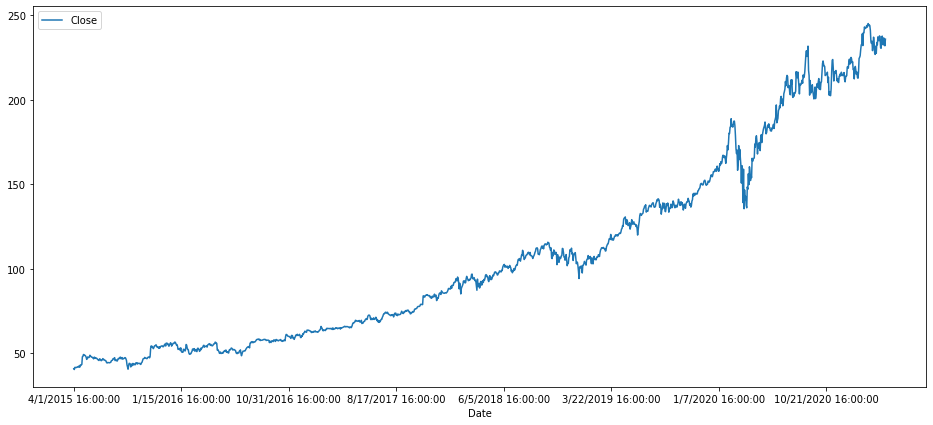

In [5]:
df.plot(x='Date',y='Close',figsize=(16,7))

In [6]:
from statsmodels.base.transform import BoxCox
 

In [7]:
bc=BoxCox()

In [8]:
df['Close'], lmbda=bc.transform_boxcox(df['Close'])

In [9]:
data=df[["Date","Close"]]
data.columns=["ds","y"]

In [10]:
model_params={
    "daily_seasonality":False,
    "weekly_seasonality": False,
    "yearly_seasonality": True,
    "seasonality_mode": "multiplicative",
    "growth": "logistic"
}

In [11]:
from fbprophet import Prophet
model=Prophet(**model_params)

data["cap"]=data['y'].max() + data['y'].std()*0.05

model.fit(data)
future=model.make_future_dataframe(periods=365)
future["cap"]=data["cap"].max()
forecast=model.predict(future)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


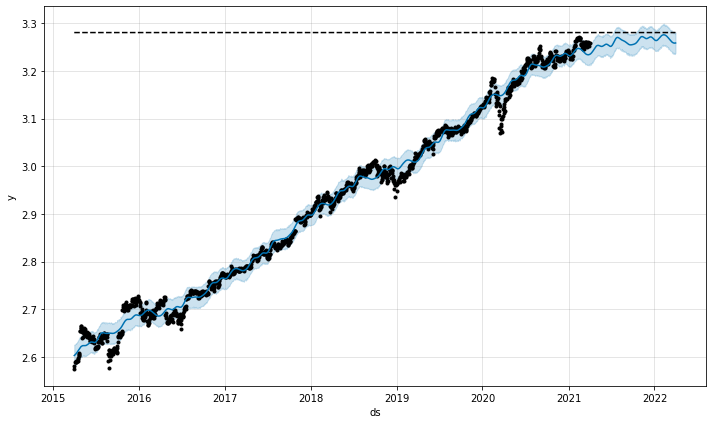

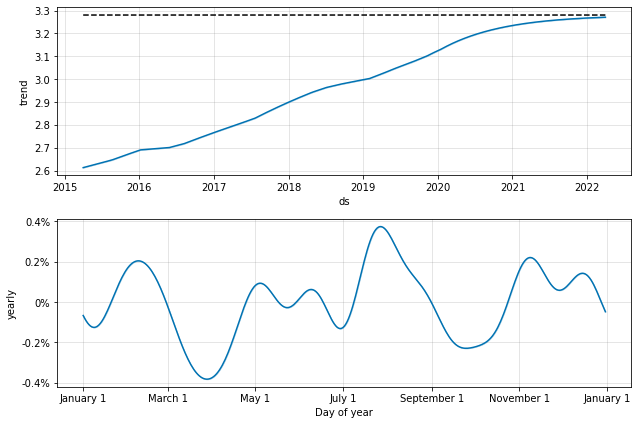

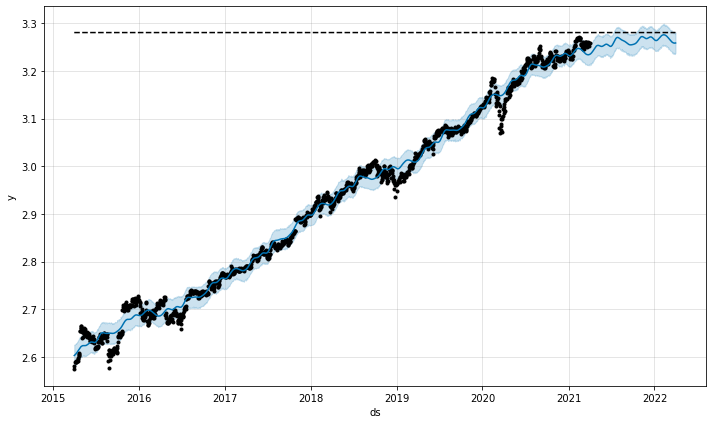

In [12]:
model.plot_components(forecast)
model.plot(forecast)

In [13]:
model=Prophet(**model_params)

model.add_seasonality(name="monthly",period=30,fourier_order=10)
model.add_seasonality(name="quaterly",period=92.95,fourier_order=10)
model.add_country_holidays("US")

model.fit(data)

future=model.make_future_dataframe(periods=365)
future["cap"]=data["cap"].max()
forecast=model.predict(future)

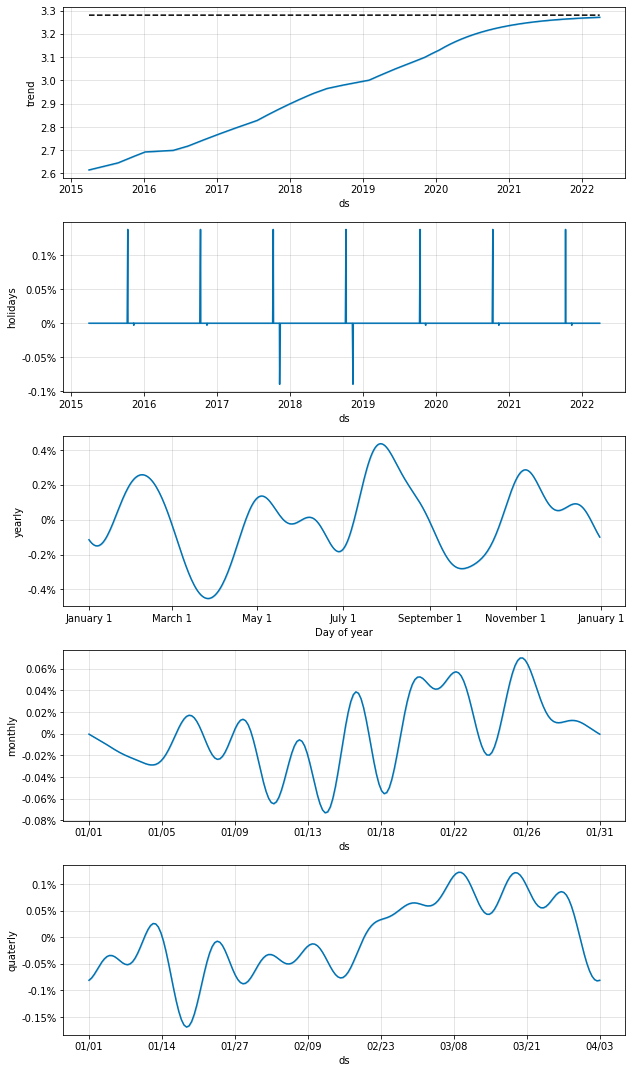

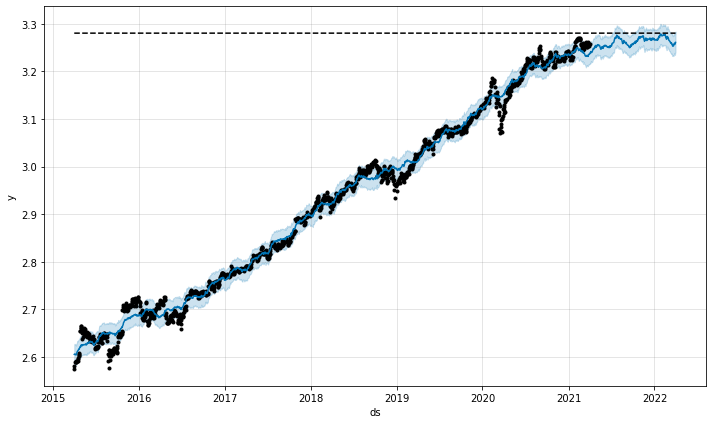

In [14]:
model.plot_components(forecast);
model.plot(forecast);

In [17]:
import itertools
import numpy as np
from fbprophet.diagnostics import cross_validation,performance_metrics

param_grid={
    "daily_seasonality":[False],
    "weekly_seasonality": [False],
    "yearly_seasonality": [True],
    "growth": ["logistic"],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]

}

all_params=[
            dict(zip(param_grid.keys(),v))
            for v in itertools.product(*param_grid.values())
]
print(all_params)


[{'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_p

In [18]:
rmses=list()

for params in all_params:
  m=Prophet(**params)
  m=m.add_seasonality(name="monthly",period=30,fourier_order=5)
  m=m.add_seasonality(name="quaterly",period=92.25,fourier_order=10)
  m.add_country_holidays(country_name="US")
  m.fit(data)
  df_cv=cross_validation(m,initial="730 days",period="365 days", horizon="365 days",parallel="processes")
  df_p=performance_metrics(df_cv,rolling_window=1)
  rmses.append(df_p['rmse'].values[0])

  best_params=all_params[np.argmin(rmses)]
  print("\nThe best params are:",best_params)

INFO:fbprophet:Making 4 forecasts with cutoffs between 2017-04-01 16:00:00 and 2020-03-31 16:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4962c30110>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Making 4 forecasts with cutoffs between 2017-04-01 16:00:00 and 2020-03-31 16:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4962795ad0>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}


INFO:fbprophet:Making 4 forecasts with cutoffs between 2017-04-01 16:00:00 and 2020-03-31 16:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f49628304d0>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}


INFO:fbprophet:Making 4 forecasts with cutoffs between 2017-04-01 16:00:00 and 2020-03-31 16:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f49628eff10>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}


INFO:fbprophet:Making 4 forecasts with cutoffs between 2017-04-01 16:00:00 and 2020-03-31 16:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f496279ce50>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Making 4 forecasts with cutoffs between 2017-04-01 16:00:00 and 2020-03-31 16:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4962bf12d0>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Making 4 forecasts with cutoffs between 2017-04-01 16:00:00 and 2020-03-31 16:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4960edaf90>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Making 4 forecasts with cutoffs between 2017-04-01 16:00:00 and 2020-03-31 16:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f49627d7c90>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0}


INFO:fbprophet:Making 4 forecasts with cutoffs between 2017-04-01 16:00:00 and 2020-03-31 16:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4960ed25d0>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0}


INFO:fbprophet:Making 4 forecasts with cutoffs between 2017-04-01 16:00:00 and 2020-03-31 16:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4962850ed0>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0}


INFO:fbprophet:Making 4 forecasts with cutoffs between 2017-04-01 16:00:00 and 2020-03-31 16:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f496279c490>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0}


INFO:fbprophet:Making 4 forecasts with cutoffs between 2017-04-01 16:00:00 and 2020-03-31 16:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f49627f9cd0>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0}


INFO:fbprophet:Making 4 forecasts with cutoffs between 2017-04-01 16:00:00 and 2020-03-31 16:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4960ed25d0>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0}


INFO:fbprophet:Making 4 forecasts with cutoffs between 2017-04-01 16:00:00 and 2020-03-31 16:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4960e54510>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0}


INFO:fbprophet:Making 4 forecasts with cutoffs between 2017-04-01 16:00:00 and 2020-03-31 16:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4962850ed0>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0}


INFO:fbprophet:Making 4 forecasts with cutoffs between 2017-04-01 16:00:00 and 2020-03-31 16:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4960e72d10>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0}


In [20]:
best_model=Prophet(**best_params)
best_model=best_model.add_seasonality(name="monthly",period=30,fourier_order=5)
best_model=best_model.add_seasonality(name="quaterl",period=92.25,fourier_order=10)
best_model.add_country_holidays(country_name="US")
best_model.fit(data)
future=best_model.make_future_dataframe(periods=365,freq='D')
future["cap"]=data["cap"].max()
forecast=best_model.predict(future)

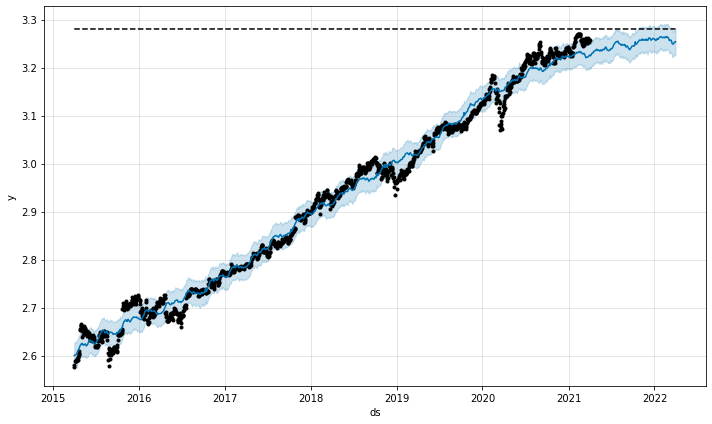

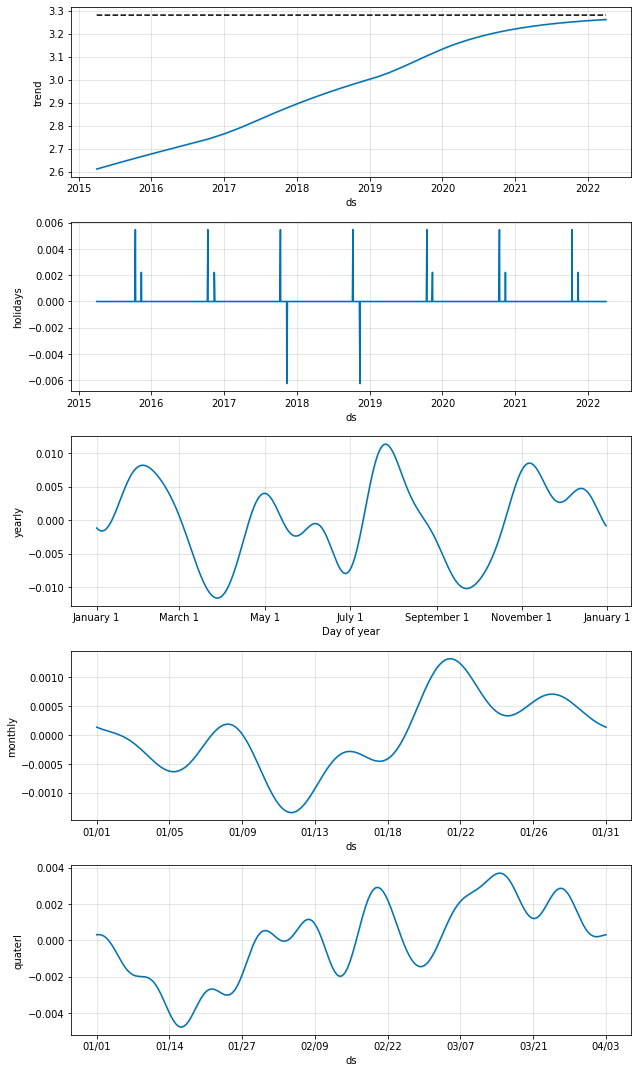

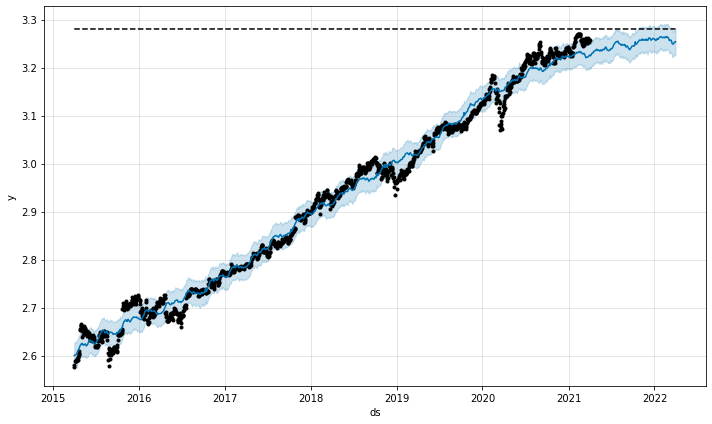

In [22]:
best_model.plot_components(forecast)
best_model.plot(forecast)

In [23]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1876 entries, 0 to 1875
Data columns (total 68 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   ds                                 1876 non-null   datetime64[ns]
 1   trend                              1876 non-null   float64       
 2   cap                                1876 non-null   float64       
 3   yhat_lower                         1876 non-null   float64       
 4   yhat_upper                         1876 non-null   float64       
 5   trend_lower                        1876 non-null   float64       
 6   trend_upper                        1876 non-null   float64       
 7   Christmas Day                      1876 non-null   float64       
 8   Christmas Day_lower                1876 non-null   float64       
 9   Christmas Day_upper                1876 non-null   float64       
 10  Christmas Day (Observed)           1

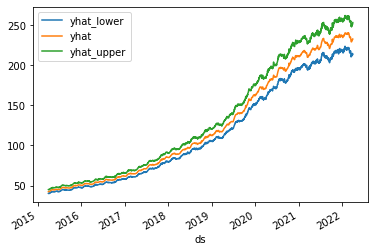

In [24]:
forecast['yhat']=bc.untransform_boxcox(x=forecast['yhat'],lmbda=lmbda)
forecast['yhat_lower']=bc.untransform_boxcox(x=forecast['yhat_lower'],lmbda=lmbda)
forecast['yhat_upper']=bc.untransform_boxcox(x=forecast['yhat_upper'],lmbda=lmbda)
forecast.plot(x='ds',y=['yhat_lower','yhat','yhat_upper'])

In [25]:
import json
from fbprophet.serialize import model_to_json,model_from_json

with open('serialized_model.json','w') as fout:
  json.dump(model_to_json(best_model), fout)

with open("serialized_model.json",'r') as fin:
  model=model_from_json(json.load(fin))

In [27]:
def warm_start(prophet_model):
  res = {}
  for pname in ['k', 'm', 'sigma_obs']:
      res[pname] = m.params[pname][0][0]
  for pname in ['delta', 'beta']:
      res[pname] = m.params[pname][0]
  return res

In [28]:
data1=data.head(-1)
model1=Prophet().fit(data)

In [29]:
%timeit Prophet().fit(data)
%timeit Prophet().fit(data, init=warm_start(model1))

1 loop, best of 5: 4.26 s per loop


RuntimeError: ignored